In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import semisupervised_vae_lib as ss_vae_lib

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import cifar_data_utils
from cifar_vae_lib import CIFARConditionalVAE
from cifar_classifier_lib import Wide_ResNet
import cifar_semisupervised_lib


In [2]:
seed = 13423
np.random.seed(seed)
_ = torch.manual_seed(seed)


# Load data

In [3]:
train_set_labeled, train_set_unlabeled, test_set = \
    cifar_data_utils.load_semisupervised_cifar_dataset(cifar100 = True, data_dir = '../cifar100_data/',
                                                       propn_sample=0.001, 
                                                      propn_labeled = 0.1)

| Preparing CIFAR dataset...
Files already downloaded and verified
| Preparing CIFAR dataset...
Files already downloaded and verified
| Preparing CIFAR dataset...
Files already downloaded and verified


In [4]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  5
num_train_unlabled:  45
num_test:  10


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

labels_legend_all = unpickle('../cifar100_data/cifar-100-python/meta')
fine_labels_legend = labels_legend_all[b'fine_label_names']

In [6]:
def plot_cifar_image(image, label):
    image_unscaled = image * cifar_data_utils.CIFAR100_STD_TENSOR + cifar_data_utils.CIFAR100_MEAN_TENSOR

    img = np.dstack((image_unscaled[0, :, :],
                            image_unscaled[1, :, :],
                            image_unscaled[2, :, :]))

    plt.imshow(img)
    plt.title(fine_labels_legend[label])

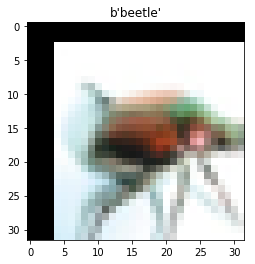

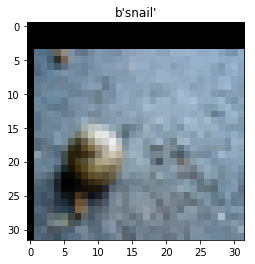

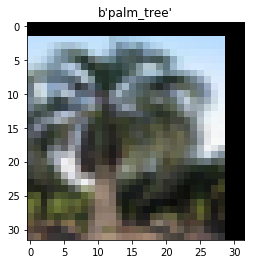

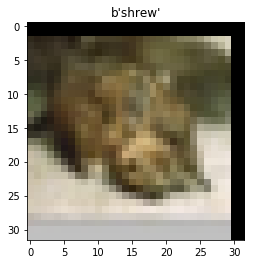

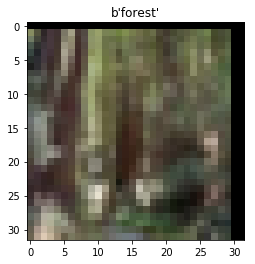

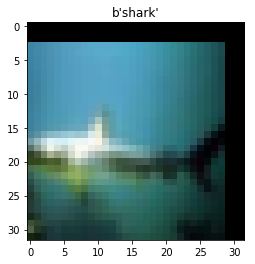

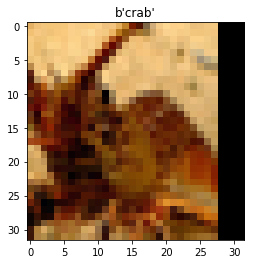

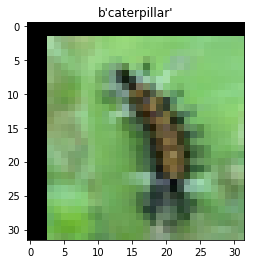

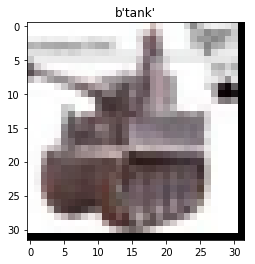

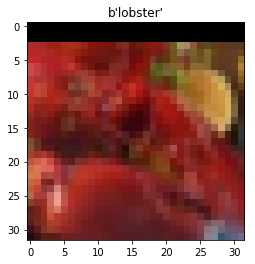

In [7]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(train_set_unlabeled[i]['image'].squeeze(), train_set_unlabeled[i]['label'])

In [8]:
slen = train_set_labeled[0]['image'].shape[-1]

# Get data loaders

In [9]:
batchsize = 5

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=train_set_labeled.num_images,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [10]:
len(train_loader_unlabeled)

9

In [11]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [12]:
data_unlabeled['image'].shape

torch.Size([5, 3, 32, 32])

In [13]:
data_labeled['image'].shape

torch.Size([5, 3, 32, 32])

In [14]:
data_test['image'].shape

torch.Size([5, 3, 32, 32])

# Define VAE

In [15]:
image_config = {'slen': 32,
                 'channel_num': 3,
                 'n_classes': 100}

cond_vae_config = {'kernel_num': 5,
                   'z_size': 2}

# classifier_config = {'depth': 10,
#                      'widen_factor': 2,
#                      'dropout_rate': 0.3}

classifier_config = {'depth': 5,
                     'k': 3}

In [16]:
cifar_vae = \
    cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config, cond_vae_config, classifier_config)

## check conditional vae

In [17]:
latent_means, latent_std, latent_samples, image_mean, image_var = \
    cifar_vae.conditional_vae.forward(data_unlabeled['image'], data_unlabeled['label'])

In [18]:
image_mean.shape

torch.Size([5, 3, 32, 32])

In [19]:
latent_means.shape

torch.Size([5, 2])

In [20]:
latent_std.shape

torch.Size([5, 2])

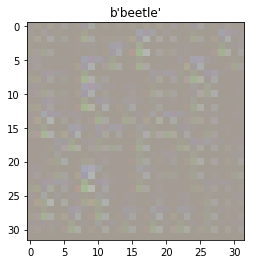

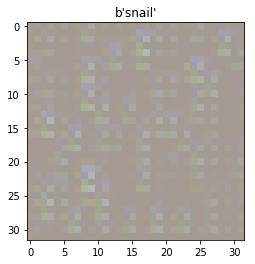

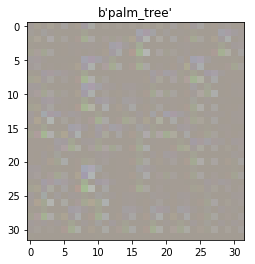

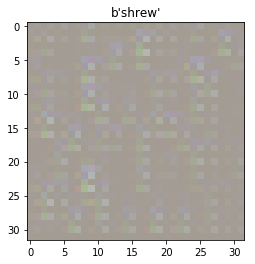

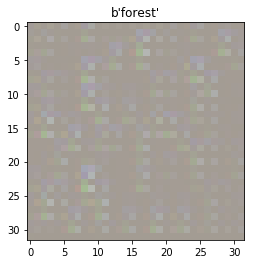

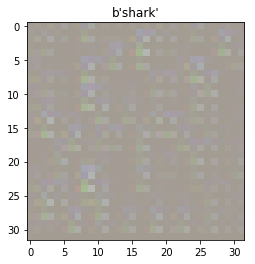

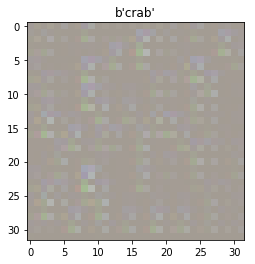

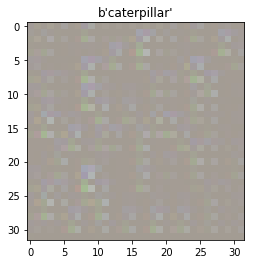

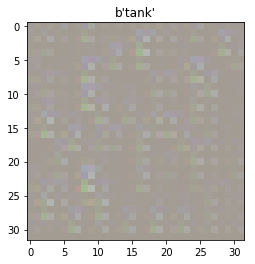

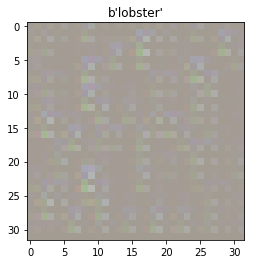

In [21]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(image_mean[0].detach(), train_set_unlabeled[i]['label'])

### check classifier

In [22]:
log_q = cifar_vae.classifier.forward(data_unlabeled['image'])

In [23]:
assert np.all(log_q.detach().numpy() < 0)

In [24]:
print(log_q.shape)

torch.Size([5, 100])


In [25]:
torch.sum(torch.exp(log_q), dim = 1)

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

### check loss goes through

In [26]:
cond_loss = cifar_vae.get_conditional_loss(data_unlabeled['image'], data_unlabeled['label'])

In [27]:
assert len(cond_loss) == len(data_unlabeled['label'])

In [28]:
cond_loss

tensor([ 2179.3838,  2217.6440,  2176.6995,  2353.3376,  2242.6904])

In [29]:
cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 1000, 1000,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

(tensor(4.4714e+06), tensor(11173.1162))

# Check gradient works 

In [30]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [31]:
vae_params0 = get_vae_params(cifar_vae)

In [32]:
assert np.any(np.isnan(vae_params0)) == False

In [33]:
optimizer = optim.Adam(cifar_vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [34]:
loss, map_loss1 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

tensor(11177.0332)


In [35]:
loss.backward()
optimizer.step()

In [36]:
vae_params1 = get_vae_params(cifar_vae)

In [37]:
assert np.any(np.isnan(vae_params1)) == False

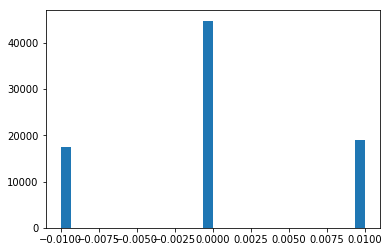

In [38]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [39]:
loss, map_loss2 = cifar_vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


In [40]:
map_loss2

tensor(11047.9688)

In [41]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [42]:
from torch.utils.data.sampler import Sampler

In [43]:
train_loader_unlabeled = None

In [44]:
ss_vae_lib.train_semisupervised_model(cifar_vae, train_loader_unlabeled, 
                                        train_loader_labeled, 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, save_every = 2, outfile = './test', 
                                        use_true_labels = False)

  * init train recon loss: 2132.741699;
  * init test recon loss: 1064.996948;
[1] unlabeled_loss: 2224.009766  	[0.0 seconds]
[2] unlabeled_loss: 2224.761475  	[0.0 seconds]
  * train recon loss: 2131.283447;
  * test recon loss: 1064.889404;
writing the conditional_vae parameters to ./test_cond_vae_epoch2

writing the classifier parameters to ./test_classifier_epoch2

debugging loss:  tensor([ 2127.1509,  2126.3999,  2126.9832,  2132.4766,  2126.4055,
         2131.5059,  2132.1787,  2126.8899,  2134.6860,  2130.8899,
         2130.5288,  2133.5979,  2133.4070,  2132.3169,  2136.7925,
         2129.4668,  2128.4072,  2133.3298,  2130.2275,  2131.2024,
         2133.8396,  2133.3647,  2128.6821,  2132.8232,  2131.1287,
         2131.8953,  2127.6956,  2135.4521,  2135.1633,  2124.9026,
         2130.9585,  2131.8040,  2129.8062,  2130.5613,  2132.3115,
         2128.9910,  2129.1858,  2128.3962,  2137.6316,  2131.5820,
         2132.5876,  2132.1494,  2133.4932,  2130.4753,  2128.5410

In [45]:
torch.exp(cifar_vae.classifier(data_unlabeled['image']).detach())

tensor(1.00000e-02 *
       [[ 0.9202,  0.8965,  0.7516,  0.8008,  0.2997,  0.8410,  0.4512,
          0.9142,  1.0922,  0.5107,  0.9604,  0.8531,  0.8859,  0.5520,
          2.2488,  0.5079,  0.7373,  0.5196,  1.5221,  1.1439,  1.3825,
          2.4294,  1.7657,  0.3117,  1.1125,  1.5621,  1.6938,  0.9034,
          1.5881,  0.8053,  0.9091,  0.3229,  0.5435,  0.3728,  0.3138,
          1.7776,  1.2843,  1.8535,  0.5890,  2.1568,  1.8925,  0.7649,
          0.6744,  0.5800,  1.3493,  1.3811,  1.1574,  1.6568,  0.4938,
          0.7180,  1.3758,  0.4996,  0.8736,  0.9814,  1.8405,  1.0616,
          1.0973,  1.0276,  0.9088,  0.4624,  0.3634,  0.4264,  1.2159,
          0.4792,  1.5570,  1.5444,  0.3683,  0.6520,  1.3983,  0.5466,
          0.3827,  1.3299,  0.7413,  1.2458,  0.3869,  0.3724,  0.8274,
          2.0302,  0.8119,  1.5368,  1.9962,  0.7310,  0.4946,  0.8147,
          1.2309,  0.7219,  0.5031,  1.4623,  0.3117,  1.6793,  1.1802,
          0.4269,  0.5821,  0.6888,  1.4512

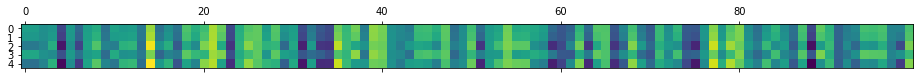

In [46]:
plt.matshow(cifar_vae.classifier(data_unlabeled['image']).detach())

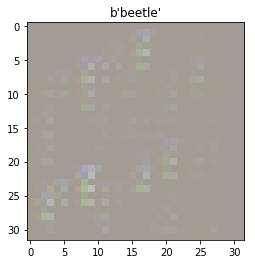

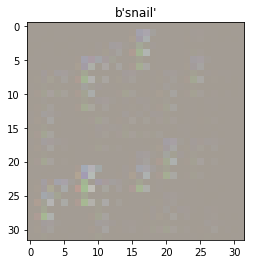

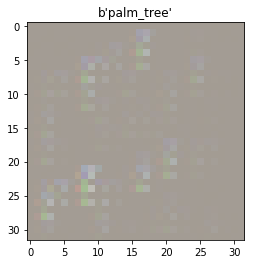

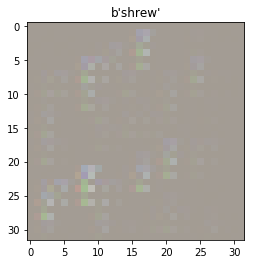

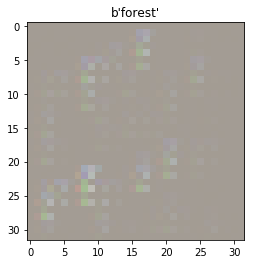

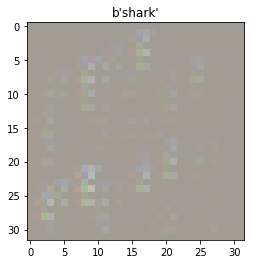

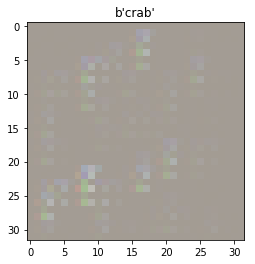

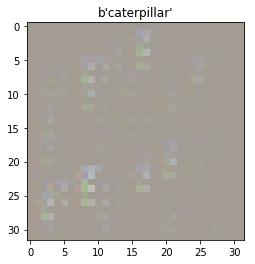

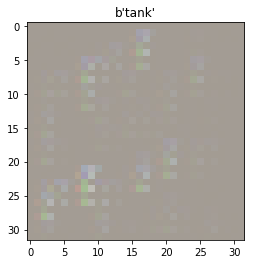

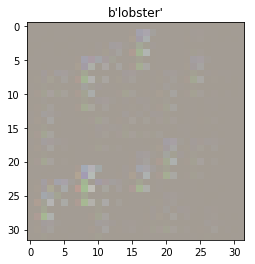

In [47]:
latent_means, latent_std, latent_samples, image_mean, image_var = \
    cifar_vae.conditional_vae.forward(data_unlabeled['image'], data_unlabeled['label'])
    
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(image_mean[0].detach(), train_set_unlabeled[i]['label'])

In [48]:
# check reloading

In [49]:
reload_cifar_vae = \
    cifar_semisupervised_lib.get_cifar_semisuperivsed_vae(image_config, cond_vae_config, classifier_config)

# mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

In [51]:
vae_file = './test_cond_vae_finalnal'
classifier_file = './test_classifier_final'

# reload_cifar_vae.conditional_vae.encoder.load_state_dict(torch.load(enc_file,
#                                map_location=lambda storage, loc: storage))

# reload_cifar_vae.conditional_vae.decoder.load_state_dict(torch.load(dec_file,
#                                map_location=lambda storage, loc: storage))

reload_cifar_vae.conditional_vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))
reload_cifar_vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


RuntimeError: Error(s) in loading state_dict for CIFARConditionalVAE:
	Missing key(s) in state_dict: "encoder.0.0.weight", "encoder.0.0.bias", "encoder.0.1.weight", "encoder.0.1.bias", "encoder.0.1.running_mean", "encoder.0.1.running_var", "encoder.1.0.weight", "encoder.1.0.bias", "encoder.1.1.weight", "encoder.1.1.bias", "encoder.1.1.running_mean", "encoder.1.1.running_var", "encoder.2.0.weight", "encoder.2.0.bias", "encoder.2.1.weight", "encoder.2.1.bias", "encoder.2.1.running_mean", "encoder.2.1.running_var", "cond_encoder.0.0.weight", "cond_encoder.0.0.bias", "cond_encoder.1.0.weight", "cond_encoder.1.0.bias", "cond_encoder.2.weight", "cond_encoder.2.bias", "cond_decoder.0.0.weight", "cond_decoder.0.0.bias", "cond_decoder.1.0.weight", "cond_decoder.1.0.bias", "cond_decoder.2.0.weight", "cond_decoder.2.0.bias", "decoder.0.0.weight", "decoder.0.0.bias", "decoder.0.1.weight", "decoder.0.1.bias", "decoder.0.1.running_mean", "decoder.0.1.running_var", "decoder.1.0.weight", "decoder.1.0.bias", "decoder.1.1.weight", "decoder.1.1.bias", "decoder.1.1.running_mean", "decoder.1.1.running_var", "decoder.2.0.weight", "decoder.2.0.bias", "decoder.2.1.weight", "decoder.2.1.bias", "decoder.2.1.running_mean", "decoder.2.1.running_var". 
	Unexpected key(s) in state_dict: "classfier.features.conv0.weight", "classfier.features.transition1.norm.weight", "classfier.features.transition1.norm.bias", "classfier.features.transition1.norm.running_mean", "classfier.features.transition1.norm.running_var", "classfier.features.transition1.conv.weight", "classfier.features.transition2.norm.weight", "classfier.features.transition2.norm.bias", "classfier.features.transition2.norm.running_mean", "classfier.features.transition2.norm.running_var", "classfier.features.transition2.conv.weight", "classfier.features.norm5.weight", "classfier.features.norm5.bias", "classfier.features.norm5.running_mean", "classfier.features.norm5.running_var", "classfier.classifier.weight", "classfier.classifier.bias". 

In [ ]:
reload_cifar_vae.eval_vae(train_loader_unlabeled, train_loader_labeled)

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset


In [ ]:
class DummyDataset(Dataset):
    """
    Dataset of numbers in [a,b] inclusive
    """

    def __init__(self, a=0, b=100):
        super(DummyDataset, self).__init__()
        self.a = a
        self.b = b

    def __len__(self):
        return self.b - self.a + 1

    def __getitem__(self, index):
        return index, "label_{}".format(index)

dataloaders1 = DataLoader(DummyDataset(0, 9), batch_size=2, shuffle=True)
dataloaders2 = DataLoader(DummyDataset(0, 4), batch_size=2, shuffle=True)

for i, data in enumerate(zip(dataloaders1, dataloaders2)):
    print(data)


In [ ]:
x, y = (1, 2)

In [ ]:
x

In [ ]:
y